Fig. 1: Concept figure
----
Uses dyngen simulated data to illustrate some of CellRank's main features. 

# Preliminaries

## Import packages

In [1]:
# import standard packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns

import os
import sys

# import single-cell packages
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [2]:
cr.logging.print_versions()

cellrank==1.0.0-rc.12+gb3e00a8 scanpy==1.6.0 anndata==0.7.4 numpy==1.19.2 numba==0.51.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 scvelo==0.2.2 pygam==0.8.0 matplotlib==3.3.2 seaborn==0.11.0


## Set up paths

Define the paths to load data, cache results and write figure panels.

In [3]:
sys.path.insert(0, "../..")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, CACHE_DIR, FIG_DIR

In [4]:
# we're only saving into one directory, so let's make life a little simples
FIG_DIR = FIG_DIR / "fig_1_concept"

Set up the paths to save figures.

In [5]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Set up caching

Note: we use a caching extension called `scachepy` for this analysis, see [here](https://github.com/theislab/scachepy). We do this to speed up the runtime of this notebook by avoiding the most expensive computations. Below, we check whether you have scachepy installed and if you don't, then we automatically recompute all results. 

In [6]:
try:
    import scachepy
    c = scachepy.Cache(CACHE_DIR / "dyngen_simulated_data", separate_dirs=True)
except ImportError:
    c = None
    
use_caching = c is not None
c

Cache(root=/Users/marius/Projects/cellrank_reproducibility/cache/dyngen_simulated_data, ext='.pickle', compression='None')

## Set global parameters

Set some plotting parameters.

In [7]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

Set other global parameters:

In [8]:
# should figures just be displayed or also saved?
save_figure = True

# should cashed values be used, or recompute?
force_recompute = False

## Load the data

Load the AnnData object from the CellRank software package. 

In [9]:
adata = scv.read(DATA_DIR / "dyngen_simulated_data" / "bifurcating.h5ad")
adata

AnnData object with n_obs × n_vars = 1000 × 250
    obs: 'cell_id', 'from', 'to', 'time', 'lineage', 'global_time', 'lin_time_sC -> sEndC', 'lin_time_sA -> sB', 'lin_time_sB -> sBmid', 'lin_time_sBmid -> sC', 'lin_time_sD -> sEndD', 'lin_time_sBmid -> sD'
    uns: 'endpoints', 'gt_velocities', 'lineage_colors', 'startpoints'
    obsm: 'X_emb', 'X_umap'
    layers: 'spliced', 'unspliced'

# Run basic analysis

## Pre-process the data, compute KNN graph

Often, we want to process the raw data a bit differently than the data in `.X`.

### Raw data

In [10]:
# create raw object
adata_raw = adata.copy()
sc.pp.filter_genes(adata_raw, min_cells=3)
scv.pp.normalize_per_cell(adata_raw)
sc.pp.log1p(adata_raw)

# annotate highly variable genes
sc.pp.highly_variable_genes(adata_raw)
adata.raw = adata_raw

filtered out 5 genes that are detected in less than 3 cells
Normalized count data: X, spliced, unspliced.
extracting highly variable genes
    finished (0:00:00)


### Data used for velocity calculation

In [11]:
# preprocessing for the actual adata object
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=34)
scv.pp.log1p(adata)

Filtered out 42 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 34 highly variable genes.


computing PCA
    on highly variable genes
    with n_comps=33
    finished (0:00:00)


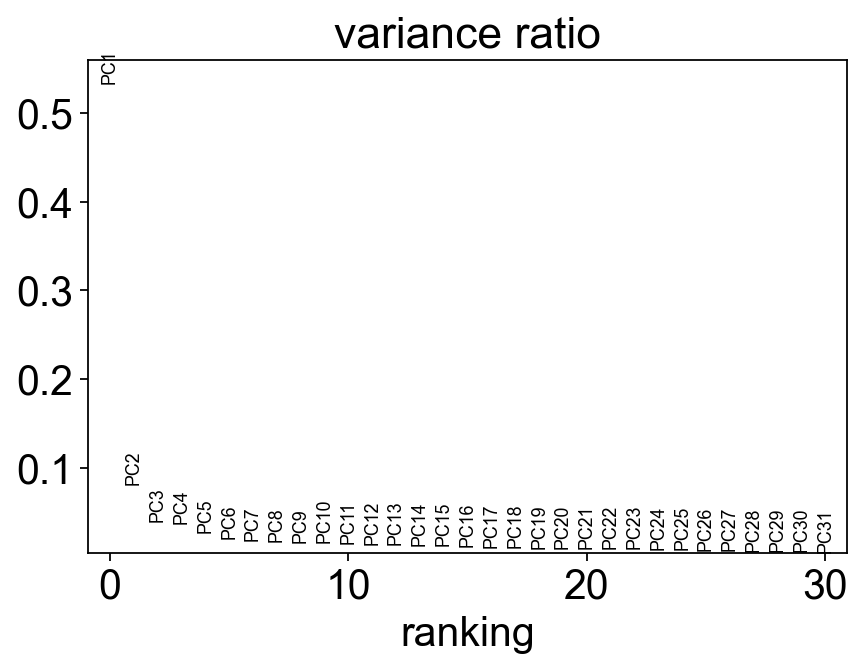

computing neighbors
    using data matrix X directly
    finished (0:00:02)


In [12]:
sc.tl.pca(adata, random_state=0)
sc.pl.pca_variance_ratio(adata)
sc.pp.neighbors(adata, n_pcs=7, n_neighbors=15, random_state=0)

## Visualise lineages in UMAP

This datset comes with a pre-computed UMAP and dyngen's lineage and time assignment. 

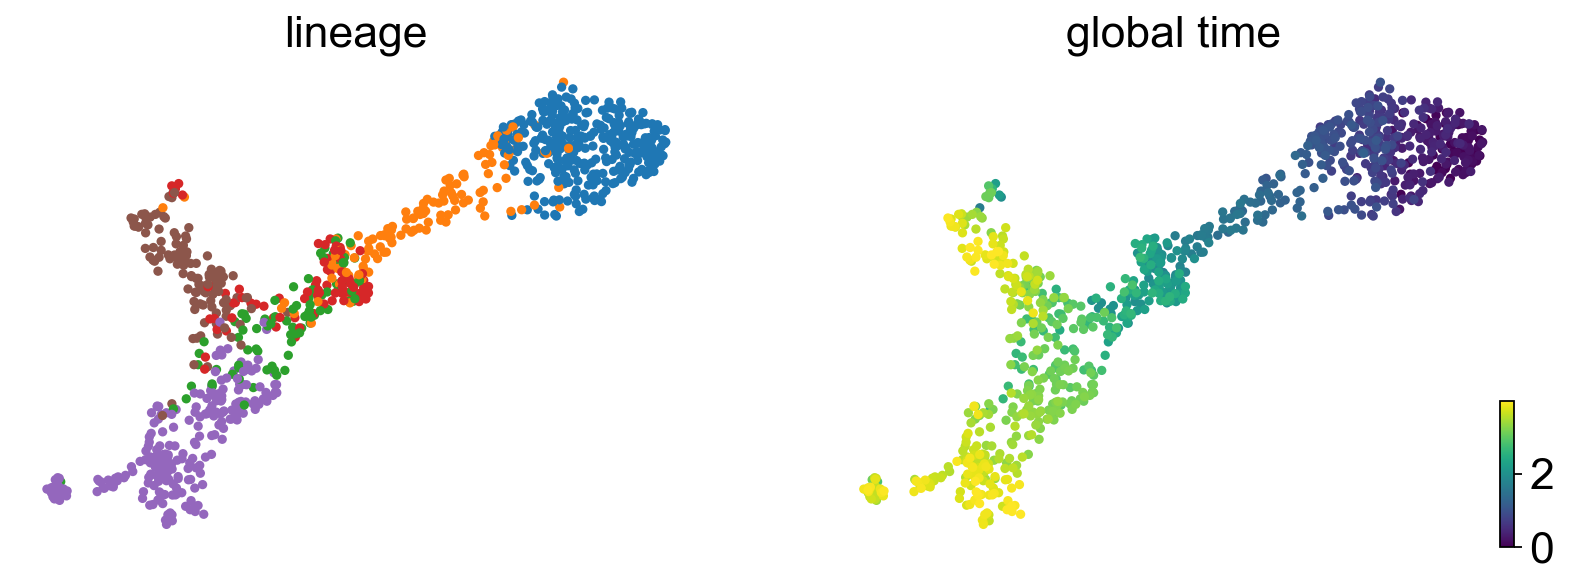

In [13]:
scv.pl.scatter(adata, color=['lineage','global_time'])

Just for the colorbar:

saving figure to file /Users/marius/Projects/cellrank_reproducibility/figures/fig_1_concept/colorbar.pdf


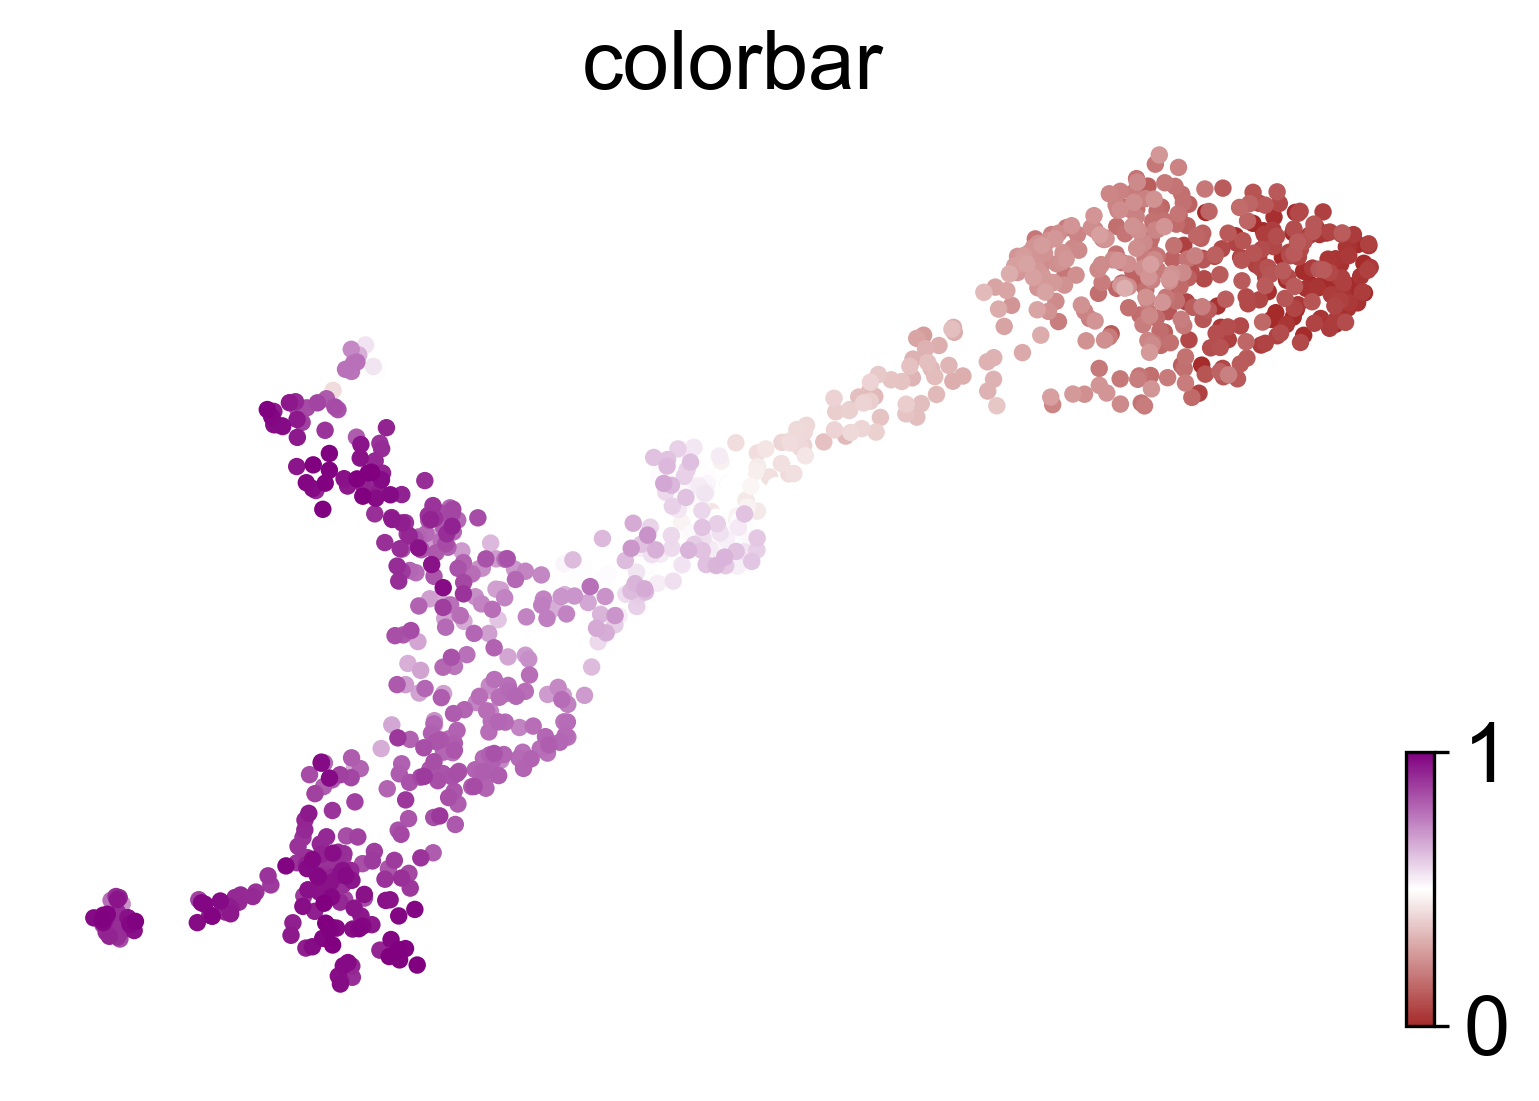

In [14]:
adata.obs['colorbar'] = adata.obs['global_time'] / np.max(adata.obs['global_time'])

fig_kwargs = {'color': 'colorbar', 'dpi': 150, 'color_map': ['brown', 'white', 'purple']}
if save_figure: fig_kwargs['save'] = "colorbar.pdf"
    
scv.pl.scatter(adata, **fig_kwargs)

## Compute velocities using scVelo

In [15]:
scv.pp.moments(adata, n_pcs=7)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [16]:
# adapt the same knn graph for the raw object and compute moments
adata_raw.obsp['connectivities'] = adata.obsp['connectivities'].copy()
adata_raw.obsp['distances'] = adata.obsp['distances'].copy()
adata_raw.uns['neighbors'] = adata.uns['neighbors'].copy()

scv.pp.moments(adata_raw, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [17]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')

recovering dynamics
    finished (0:00:06) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Project velocities onto the embedding

Often, we want to show velocities in the UMAP embedding here.

computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


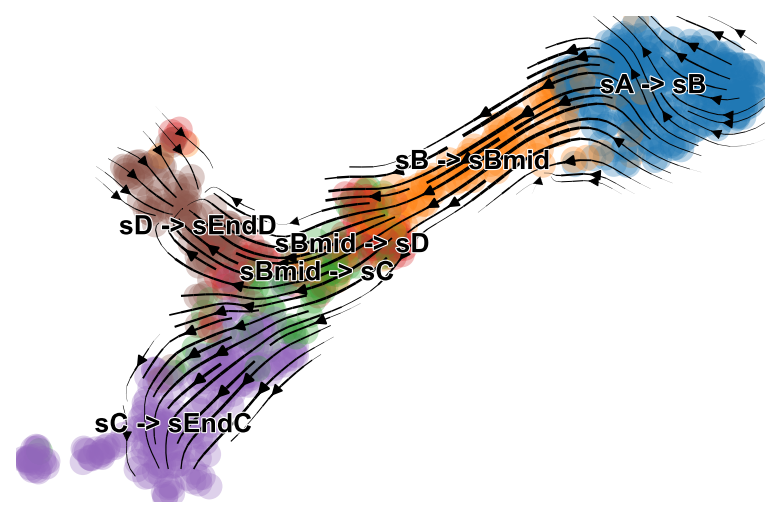

In [18]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, legend_fontsize=12, title='', smooth=0.8, min_mass=2.5, 
                                color='lineage')

## Show velocities in 3D

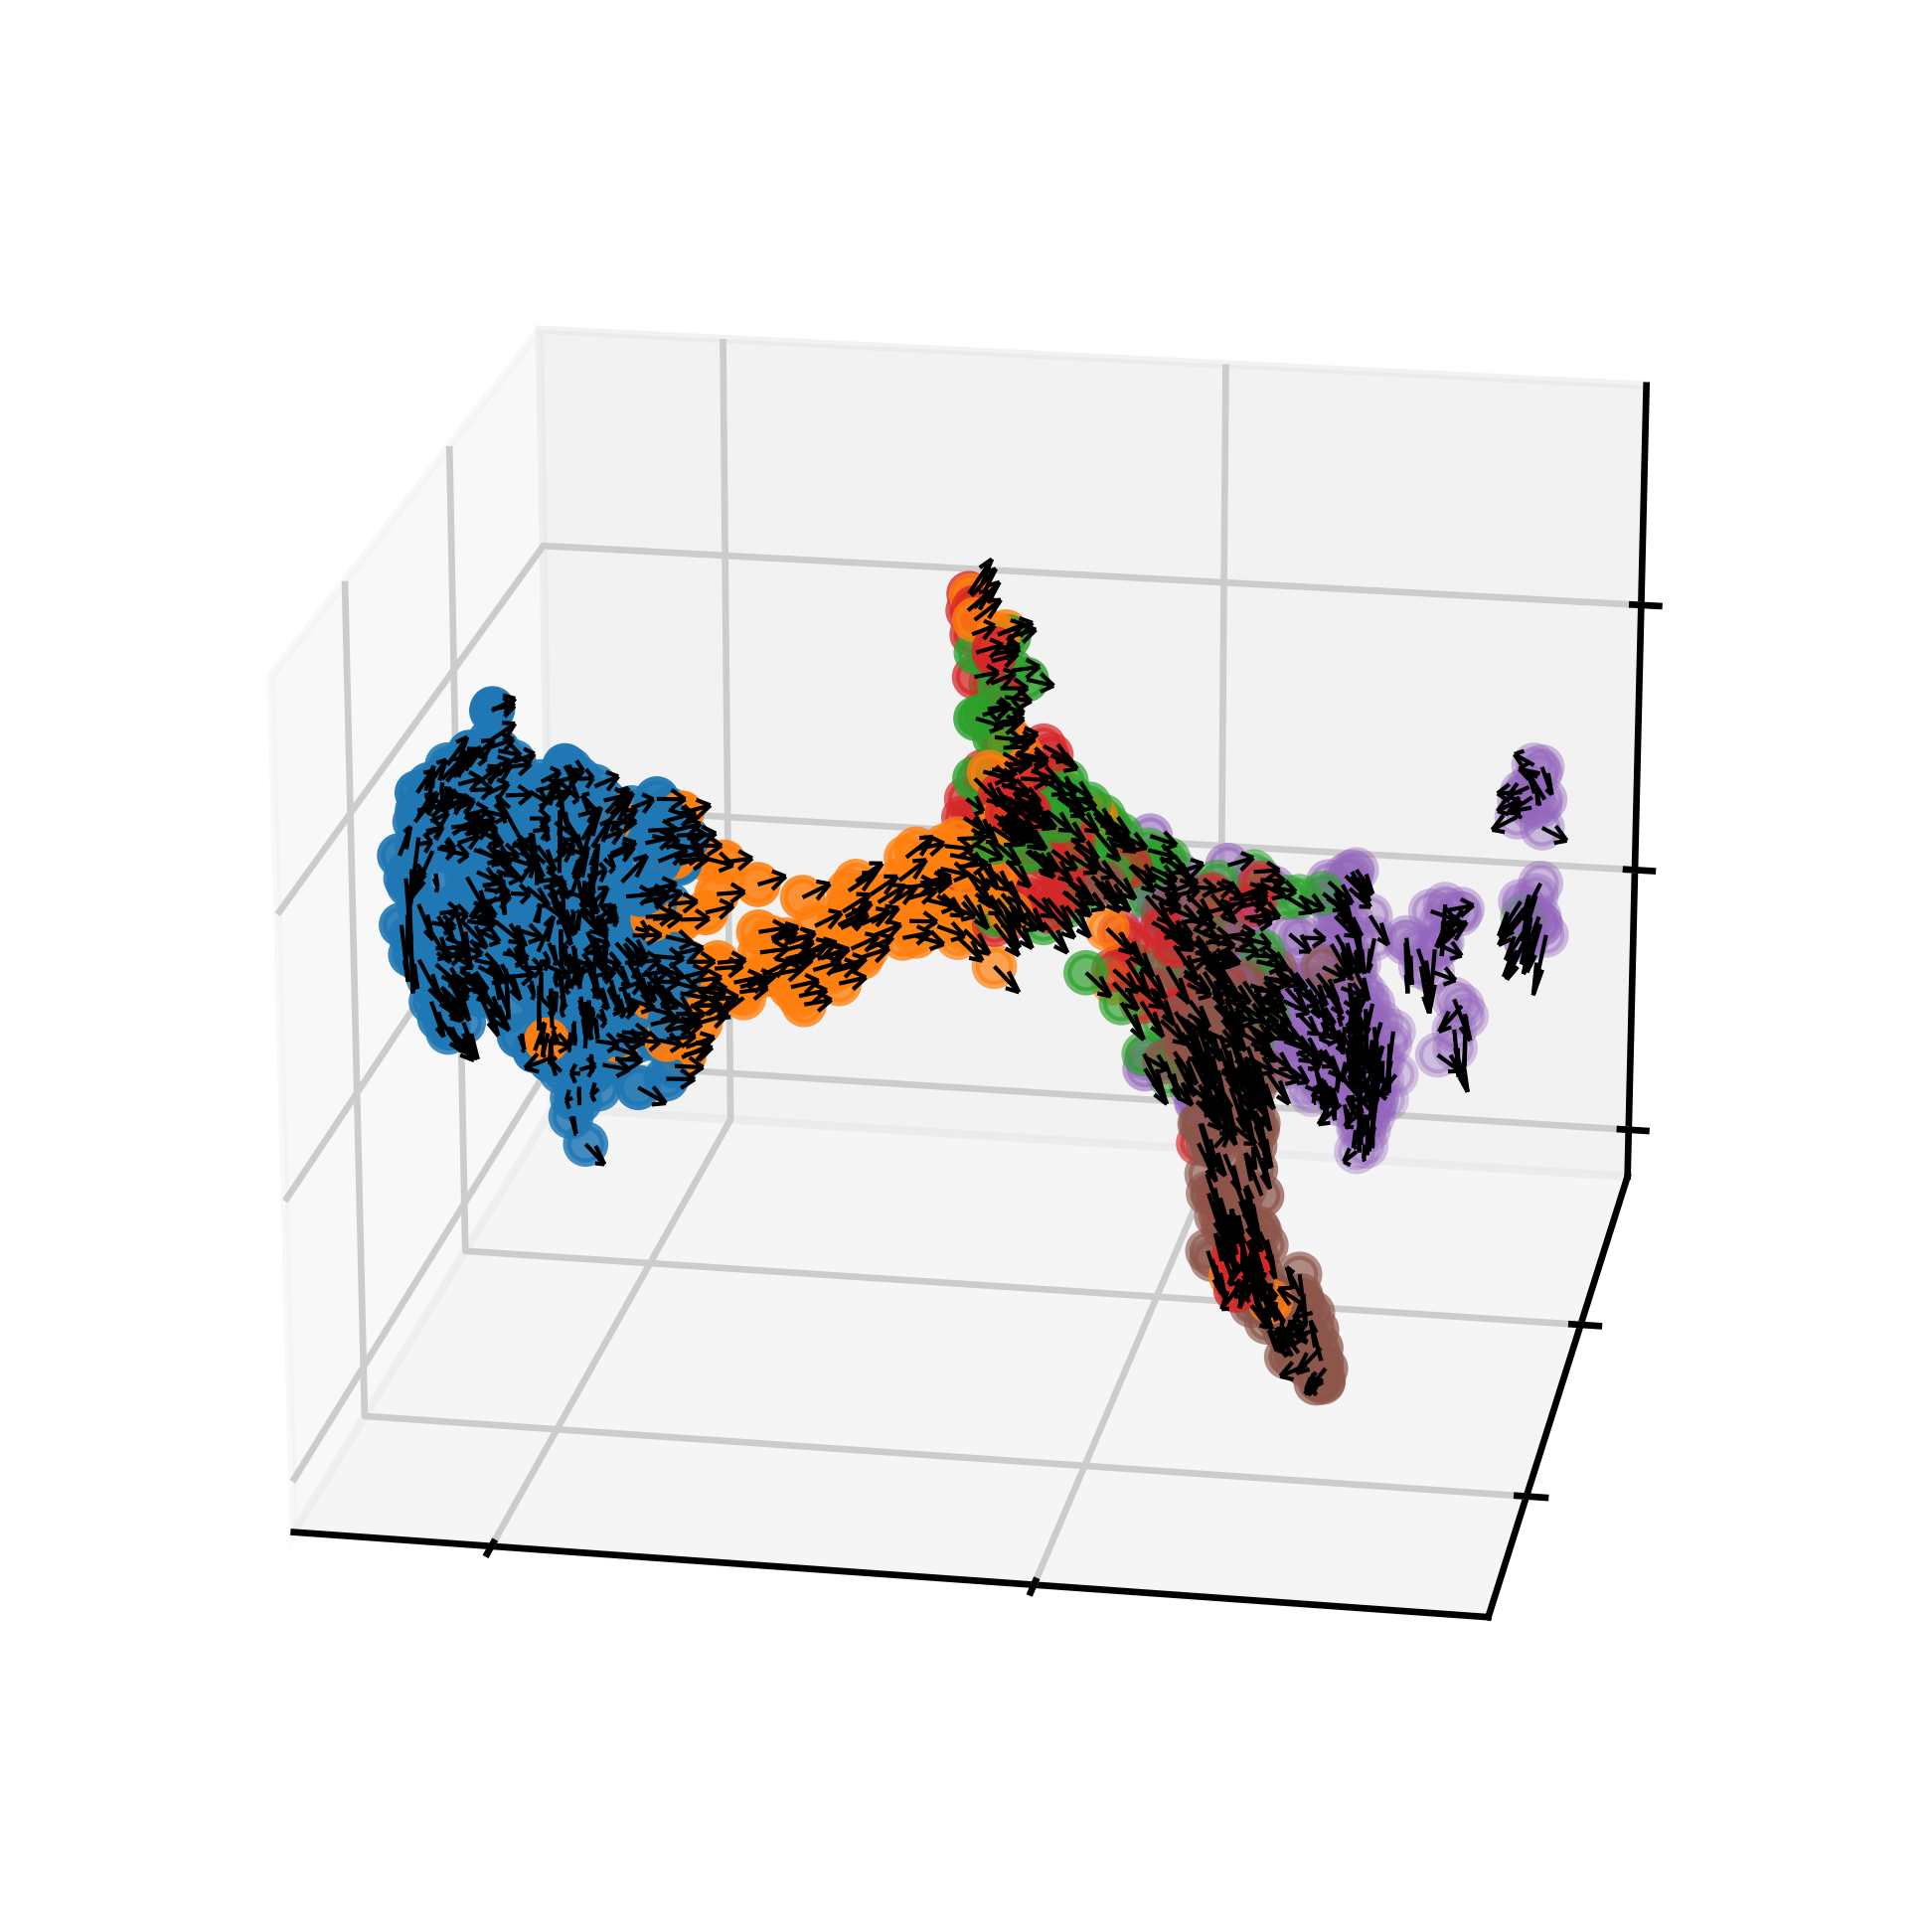

In [19]:
umap = adata.obsm['X_umap']
velocity = adata.obsm['velocity_umap']
color = scv.utils.interpret_colorkey(adata, c="lineage")

fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap[:, 0], umap[:, 1], umap[:, 2], c=color, cmap='viridis')

# Plot the velocity projection
ax.quiver(umap[:, 0], umap[:, 1], umap[:, 2], velocity[:, 0], velocity[:, 1], velocity[:, 2], color='k',
          normalize=True, length=0.5, arrow_length_ratio=0.5, linewidth = 0.5)

ax.view_init(20, 100)

# turn off the axis ticks
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.savefig(FIG_DIR / "high_dim_projection.pdf")
plt.show()

# Run CellRank

Typically, the second part of the analysis will involve CellRank. 

## Initialise kernel and estimator

This serves as an example of how to cach a transition matrix and of the default values we should be using. 

In [20]:
from cellrank.tl.estimators import GPCCA

# set the parameters we want to use to compute the transition matrix
weight_connectivities=0.2
mode="stochastic" 
n_jobs=8
softmax_scale=None

if use_caching:
    c.tl.transition_matrix(adata, 
                           weight_connectivities=weight_connectivities, 
                           mode=mode, 
                           n_jobs=n_jobs, 
                           softmax_scale=softmax_scale, 
                           fname='2020-10-15_transition_matrix_stochastic', 
                           force=force_recompute)
    g_fwd = GPCCA(adata, obsp_key='T_fwd')
else:
    kernel = cr.tl.transition_matrix(adata, 
                                     weight_connectivities=weight_connectivities, 
                                     mode=mode, 
                                     n_jobs=n_jobs, 
                                     softmax_scale=softmax_scale)
    g_fwd = GPCCA(kernel)
    
print(g_fwd)

Loading data from: `2020-10-15_transition_matrix_stochastic.pickle`.
GPCCA[n=1000, kernel=<Precomputed[origin='array']>]


## Print transition matrix statistics for reproducibility

To make sure that we're using the same transition matrix, show some stats. 

In [21]:
# just for consistency, display some summary staes about the transition matrix
T = adata.obsp['T_fwd']
T_med, T_mean, T_var = np.median(T.data), np.mean(T.data), np.var(T.data)
T_min, T_max = np.min(T.data), np.max(T.data)

print(f'med = {T_med:.6f},\nmean = {T_mean:.6f},\nvar = {T_var:.6f},\nmin = {T_min:.6f},\nmax = {T_max:.6f}')

med = 0.016503,
mean = 0.023255,
var = 0.000491,
min = 0.000572,
max = 0.505404


## Compute the real Schur decomposition

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[6, 9]`
Adding `.eigendecomposition`
       `adata.uns['eig_fwd']`
       `.schur`
       `.schur_matrix`
    Finish (0:00:01)


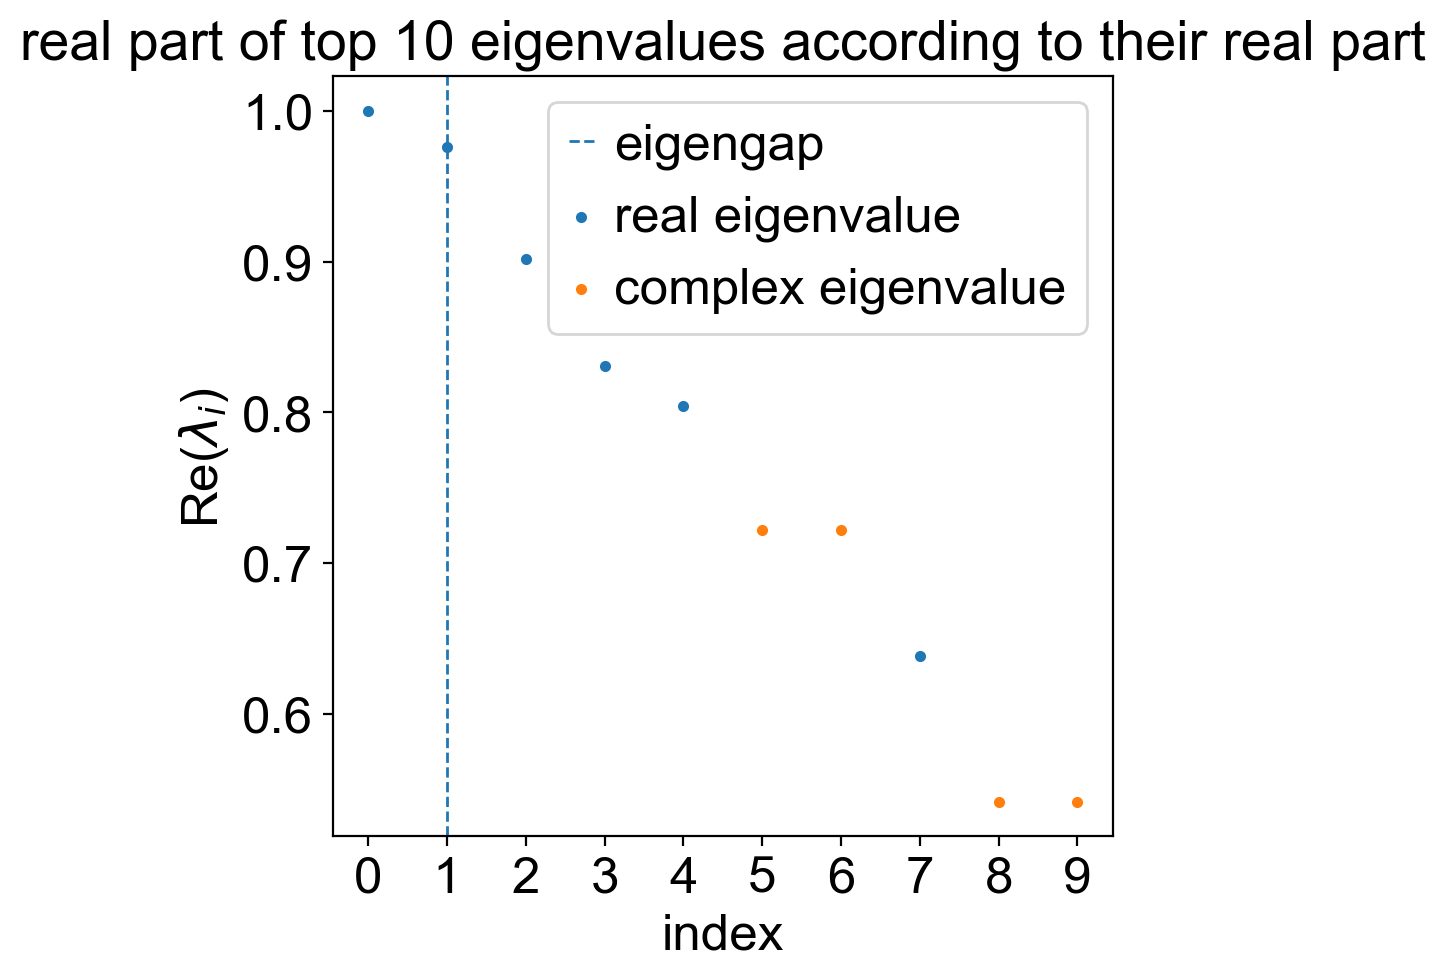

In [22]:
g_fwd.compute_schur()
g_fwd.plot_spectrum(real_only=True)

## Decompose into macrostates

Computing `4` macrostates
INFO: Using pre-computed schur decomposition
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:00)
saving figure to file /Users/marius/Projects/cellrank_reproducibility/figures/fig_1_concept/macrostates.pdf


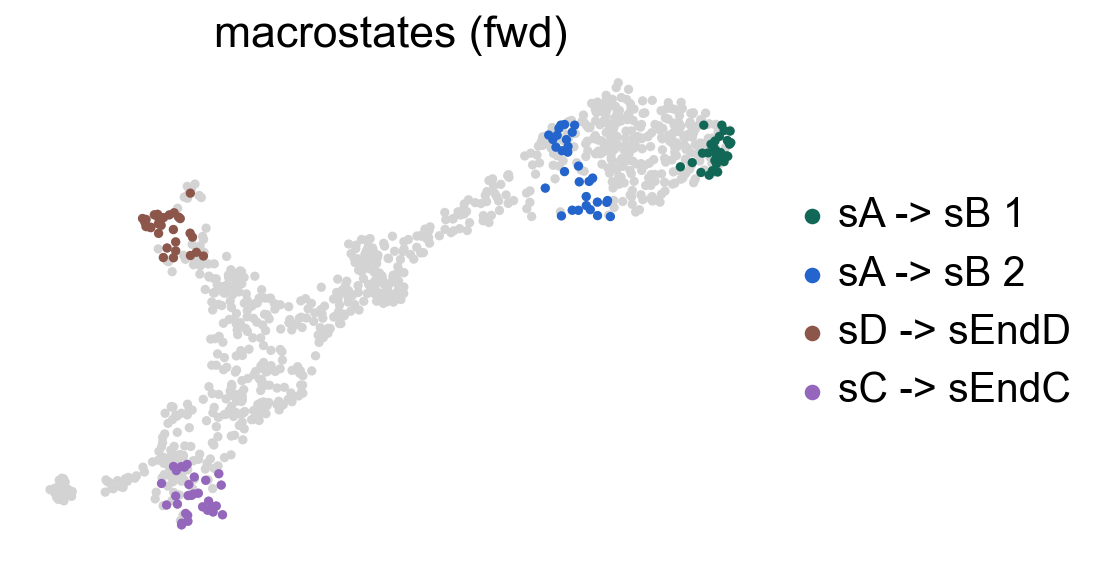

In [23]:
g_fwd.compute_macrostates(n_states=4, cluster_key='lineage')

fig_kwargs = {'discrete': True, 'legend_loc': 'right'}
if save_figure: fig_kwargs['save'] = "macrostates.pdf"
g_fwd.plot_macrostates(**fig_kwargs)

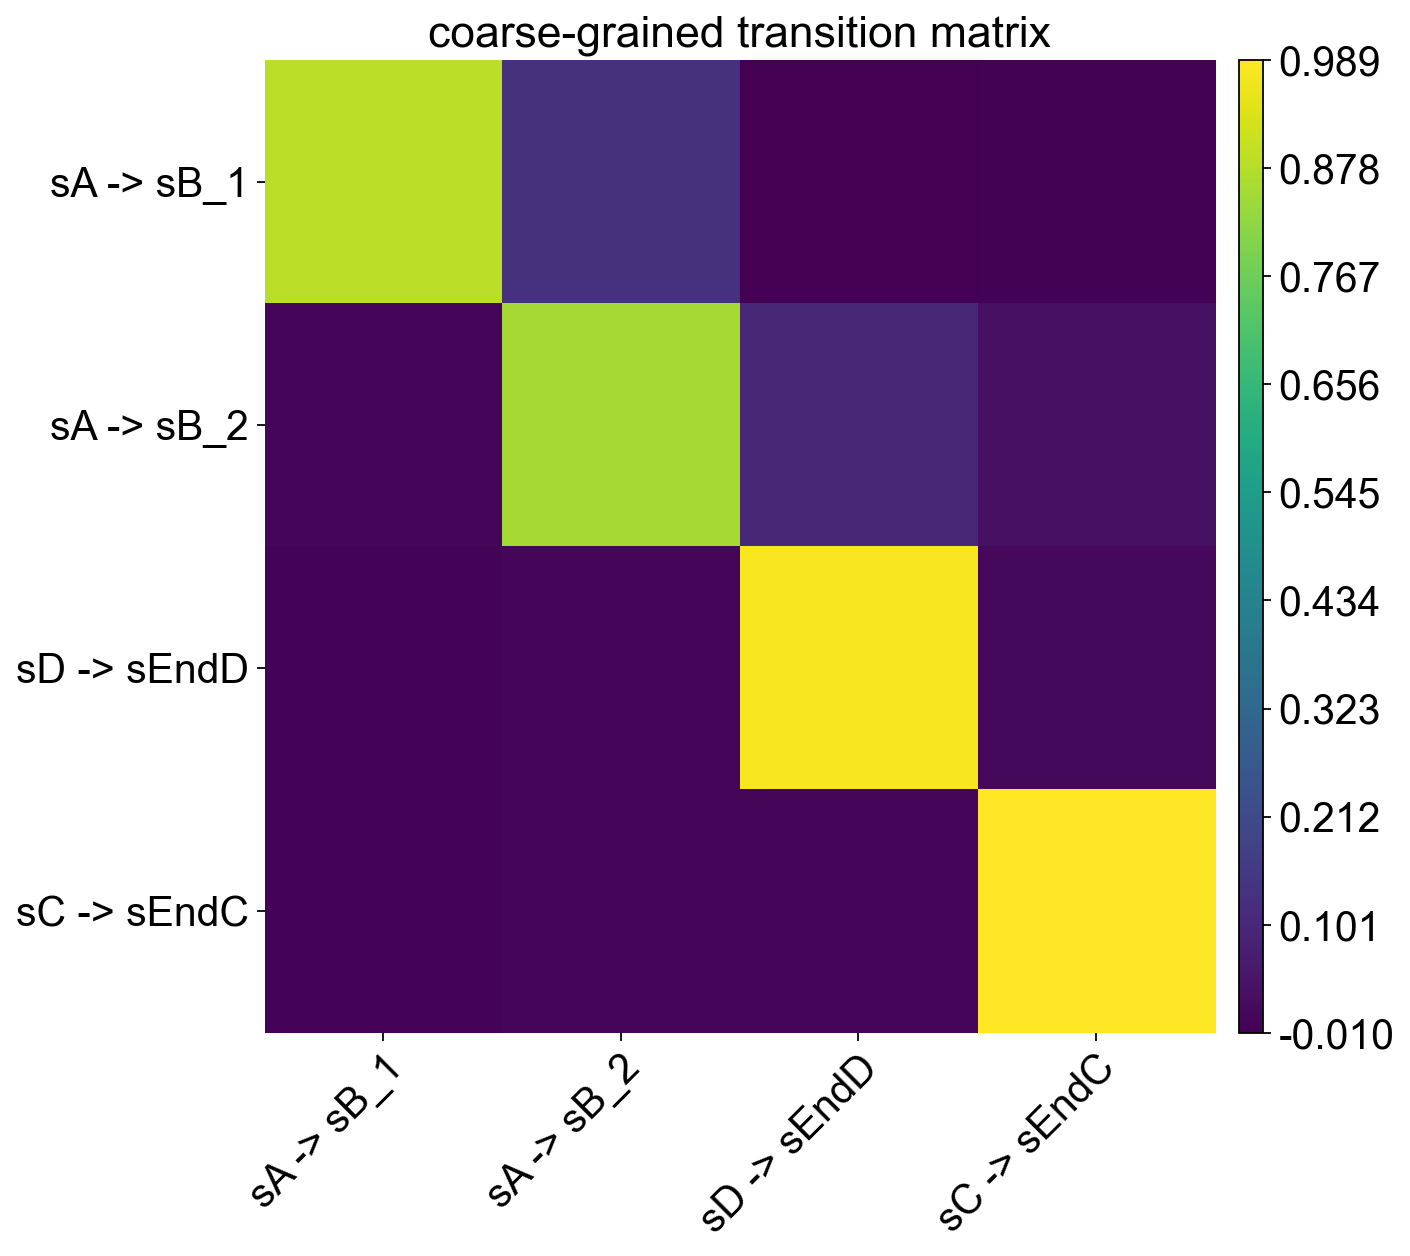

In [24]:
fig_kwargs = {'text_kwargs': {'fontsize': 40}, 'show_stationary_dist': False, 'annotate': False, 'cmap': 'viridis'}
if save_figure: fig_kwargs['save'] = "transition_matrix_coarse.pdf"
g_fwd.plot_coarse_T(**fig_kwargs)

## Identify initial and terminal states

Automatically determine initial and terminal states here.

Adding `adata.obs['terminal_states_probs']`
       `adata.obs['terminal_states']`
       `adata.obsm['macrostates_fwd']`
       `.terminal_states_probabilities`
       `.terminal_states`
Adding `adata.obs['initial_states_probs']`
       `adata.obs['initial_states']`



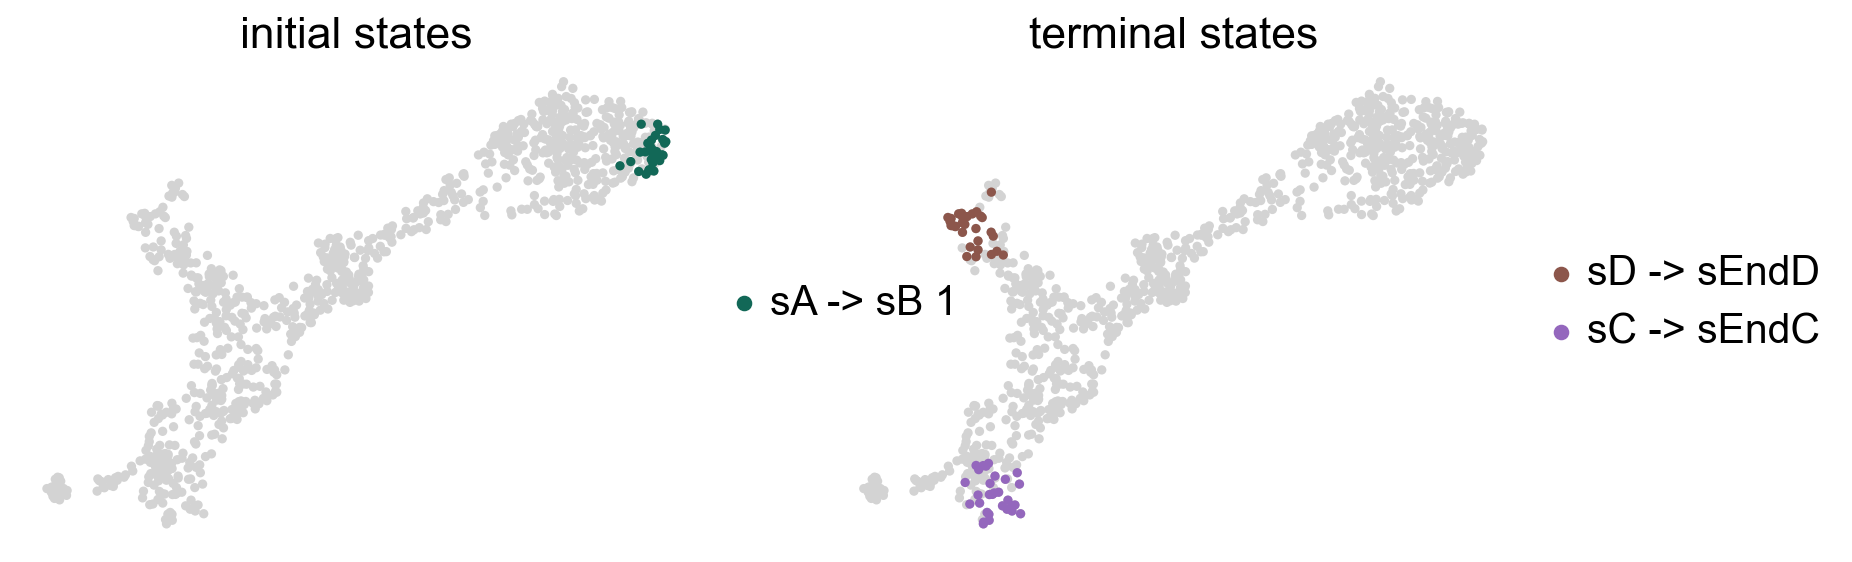

In [25]:
g_fwd.compute_terminal_states()
g_fwd._compute_initial_states()

# plot using scvelo
scv.pl.scatter(adata, c=['initial_states', 'terminal_states'], legend_loc='right')

## Plot the transition matrix

In [26]:
# get the transition matrix
T = adata.obsp['T_fwd'].A

# sort the cells by macrostate membership
meta_states_probs = g_fwd.macrostates_memberships
cell_assignment = meta_states_probs.argmax(1).X.flatten()
p = np.argsort(cell_assignment)
print(meta_states_probs.names)

['sA -> sB_1' 'sA -> sB_2' 'sD -> sEndD' 'sC -> sEndC']


Look at the distribution of non-zero values

<AxesSubplot:ylabel='Density'>

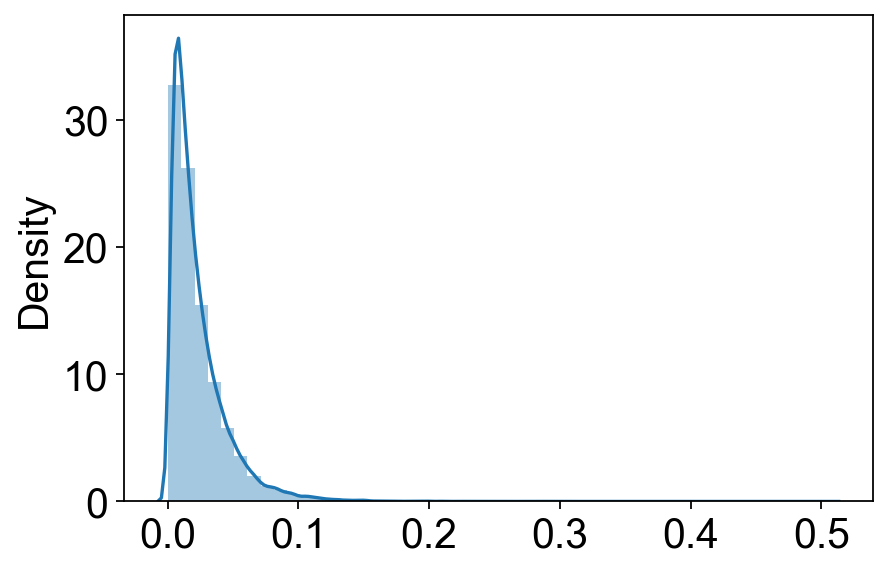

In [27]:
sns.distplot(T[T>0])

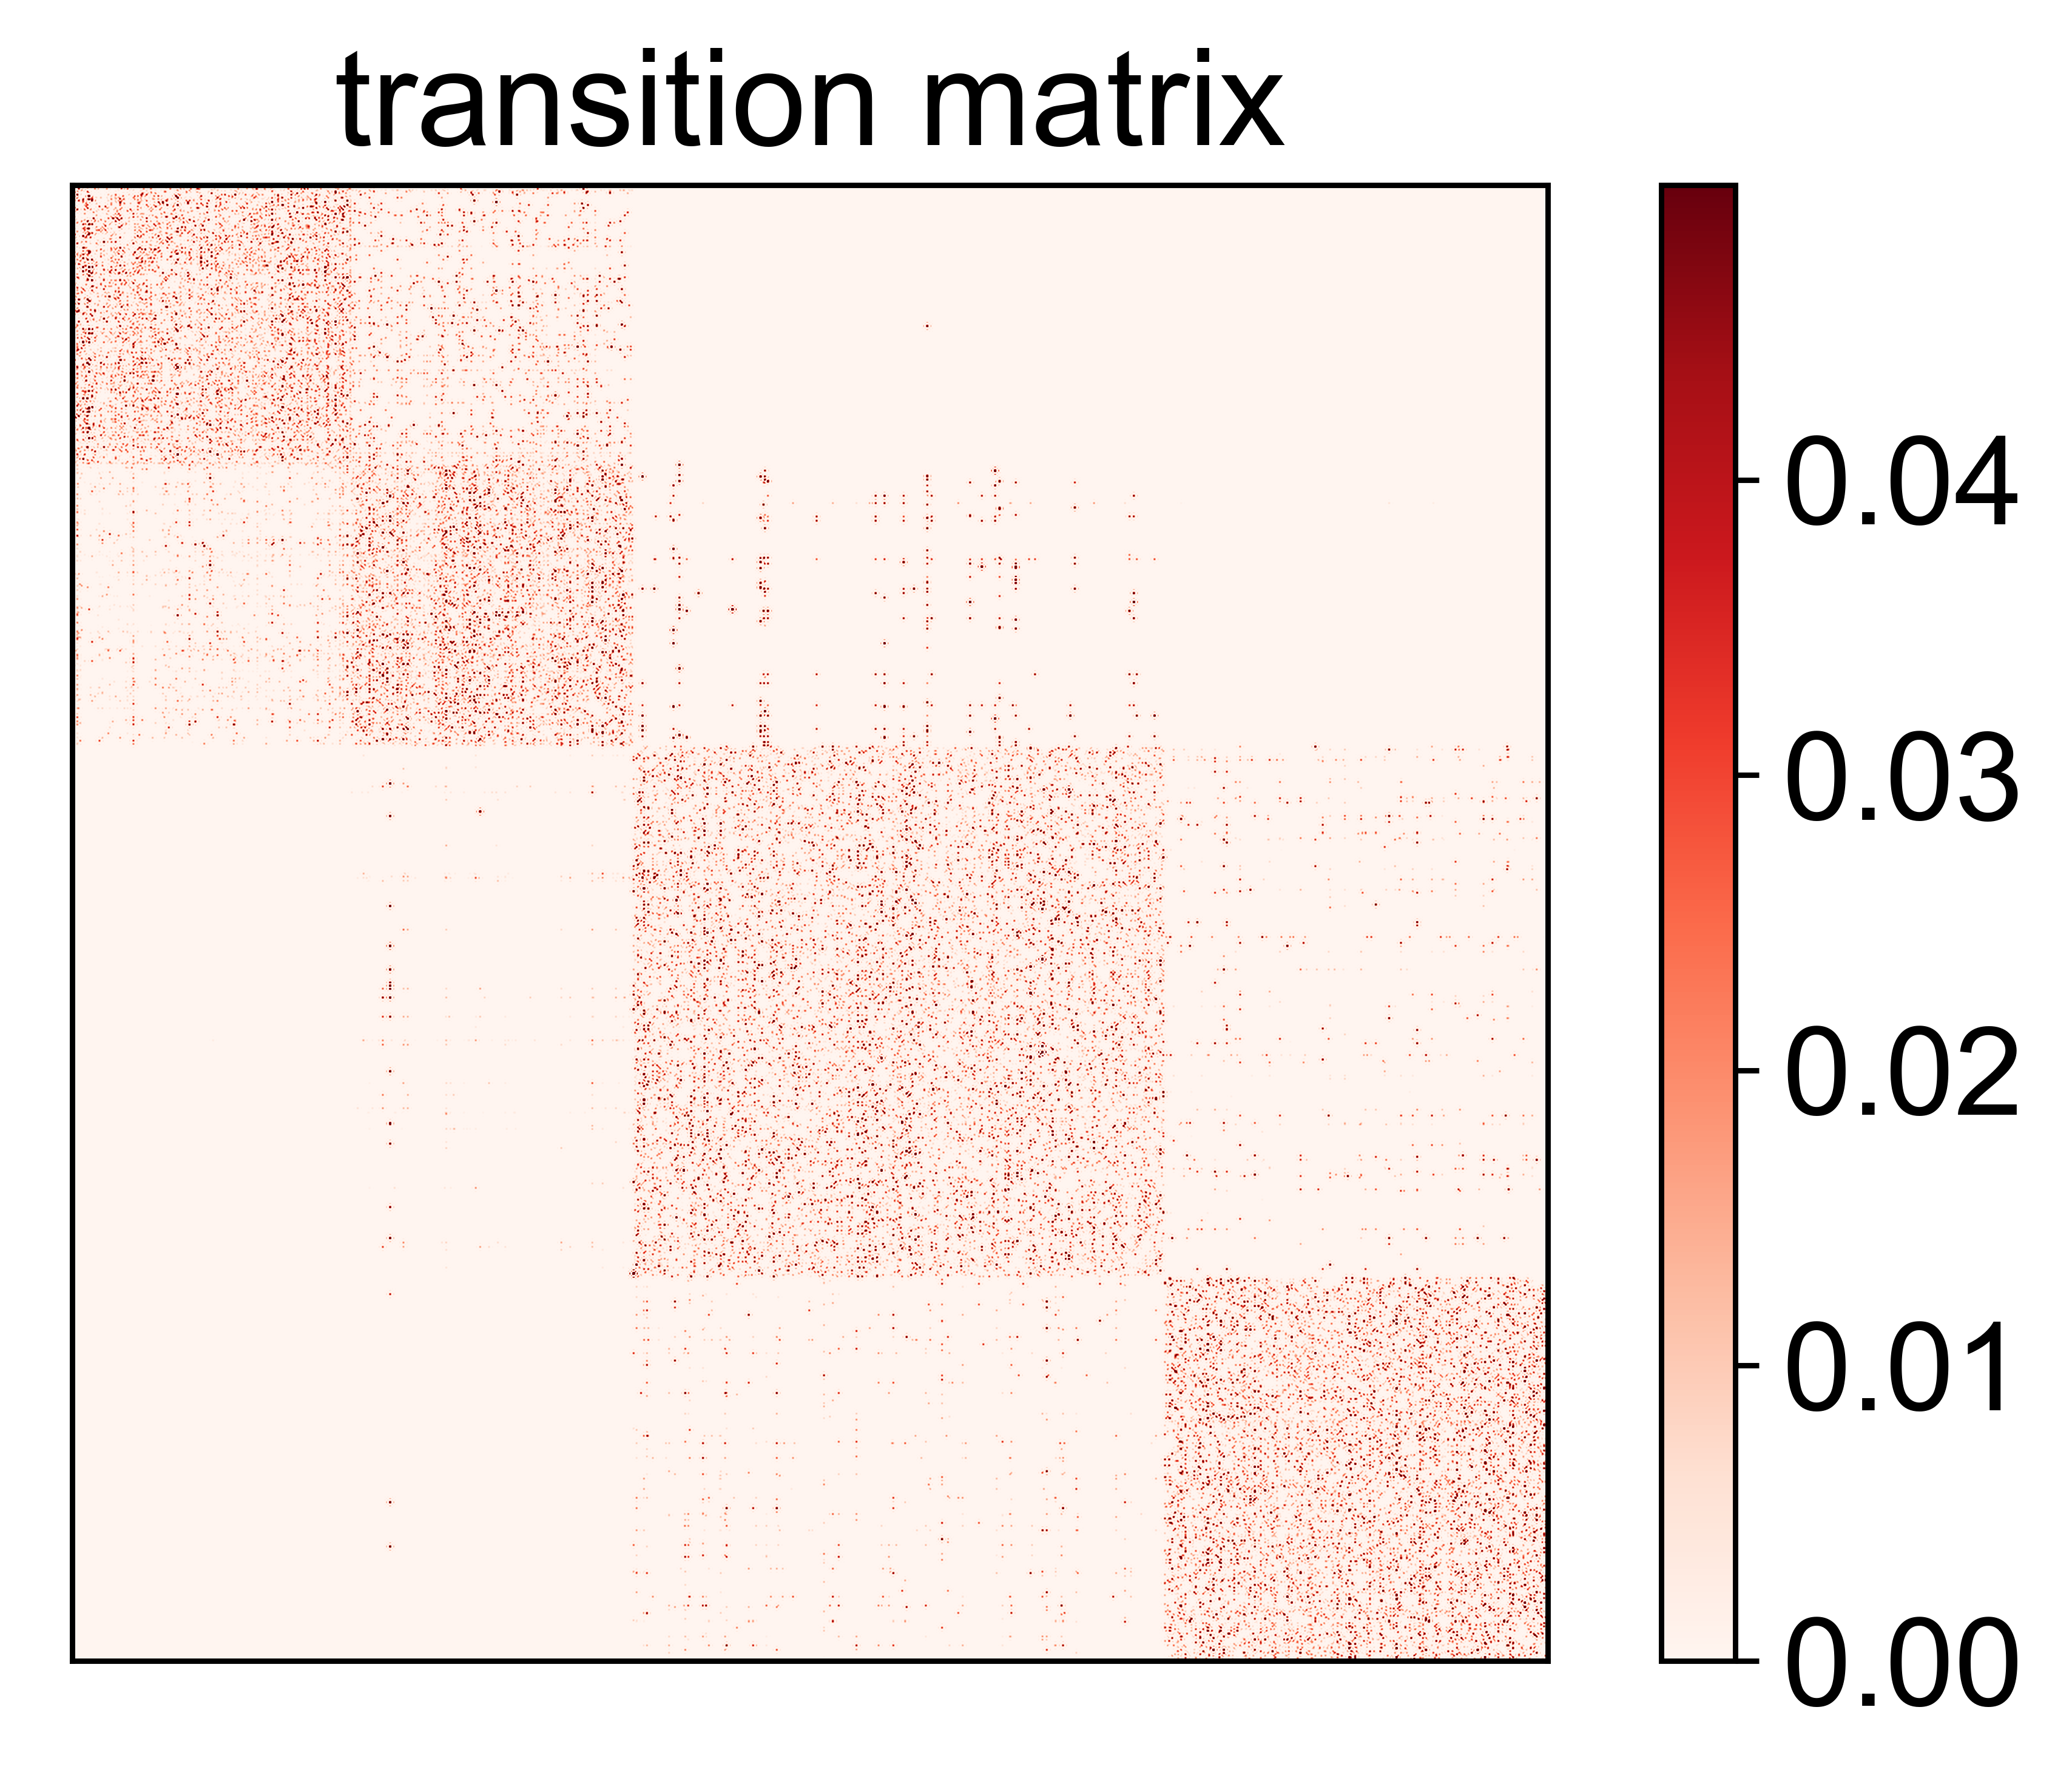

In [28]:
vmax = np.quantile(T[T>0], 0.90)

fig = plt.figure(None, dpi=400)
ax = fig.add_subplot(111)

cax = ax.imshow(T[p ,:][:, p], vmin=0, vmax=vmax, cmap='Reds', interpolation='sinc', filterrad=4.0)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('transition matrix')

plt.colorbar(mappable=cax)
plt.savefig(FIG_DIR / "transition_matrix.pdf", bbox_inches='tight')
plt.show()

## Compute absorption probabilities

Computing absorption probabilities
Adding `adata.obsm['to_terminal_states']`
       `adata.obs['to_terminal_states_dp']`
       `.absorption_probabilities`
       `.diff_potential`
    Finish (0:00:00)
saving figure to file /Users/marius/Projects/cellrank_reproducibility/figures/fig_1_concept/fate_map.pdf


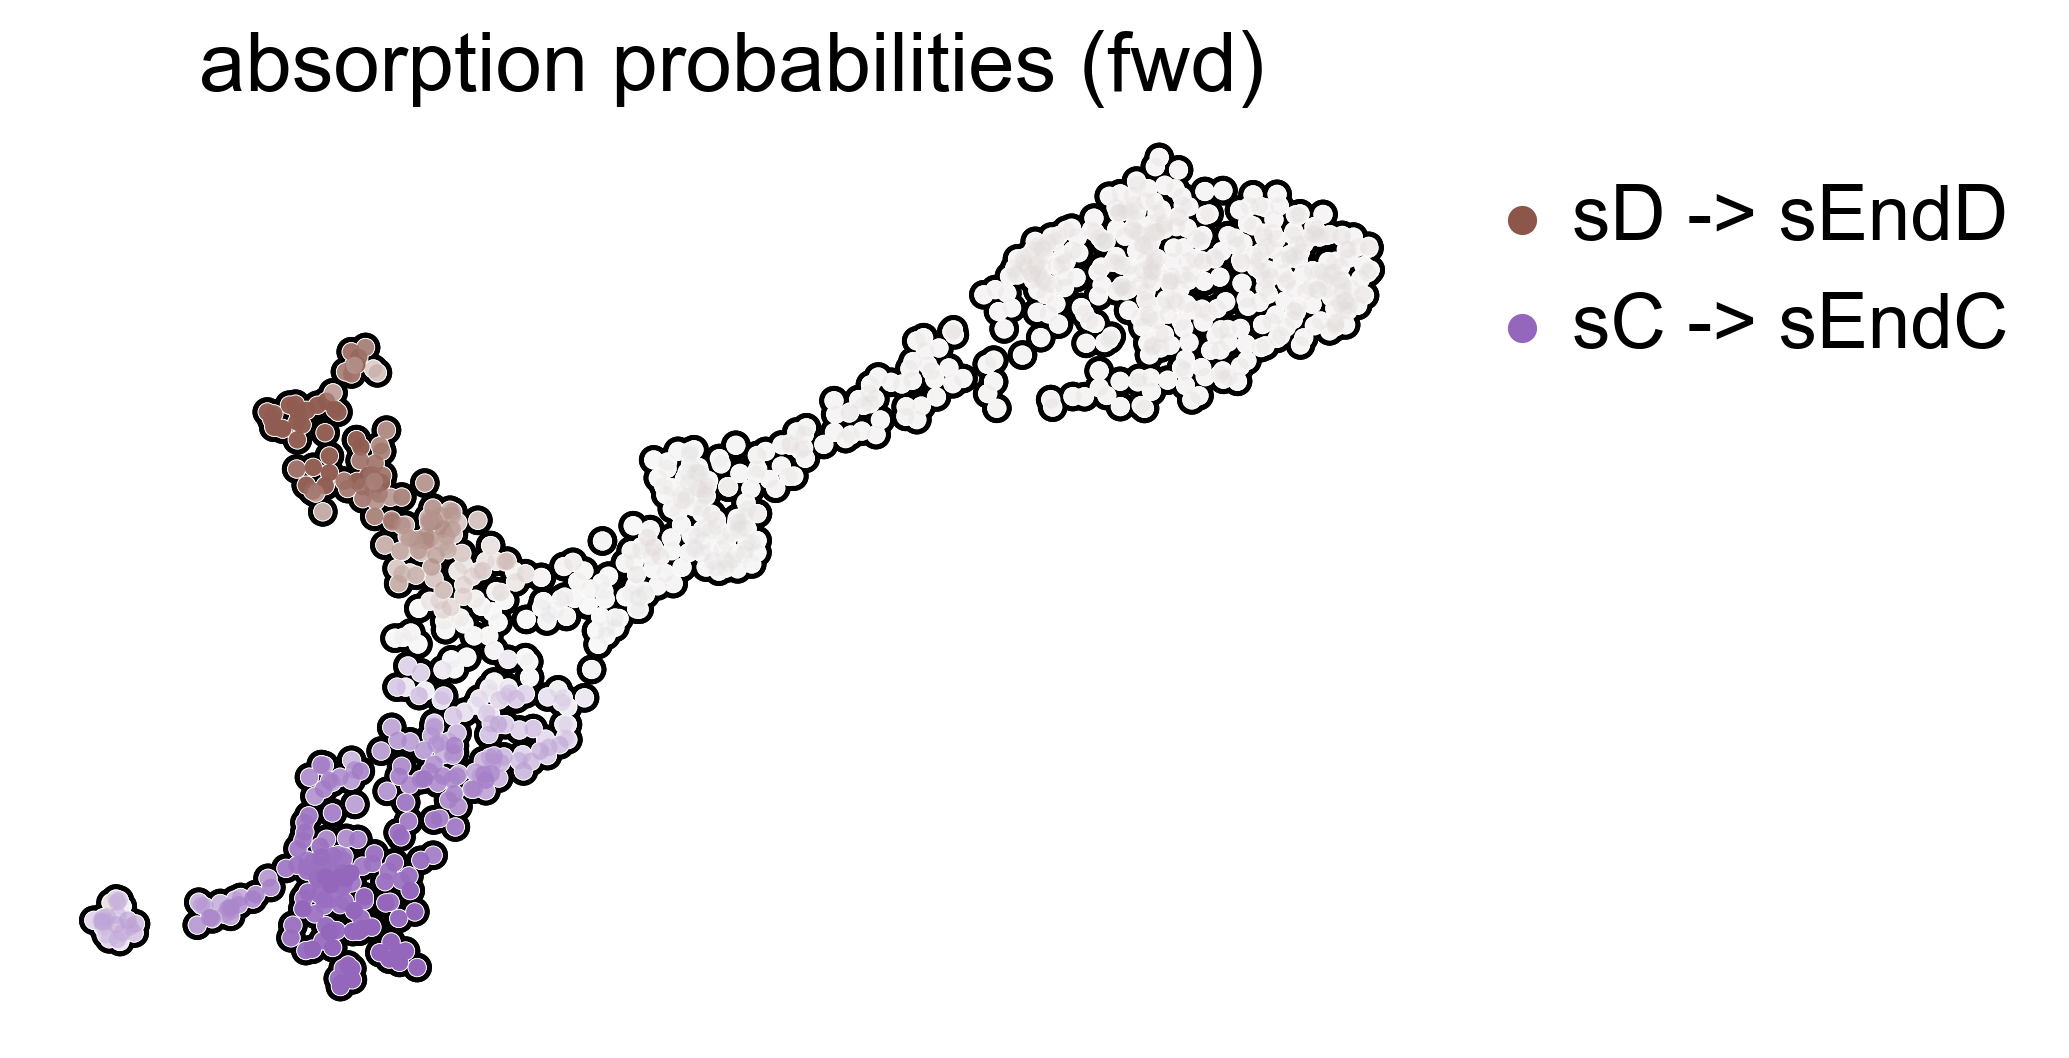

In [29]:
g_fwd.compute_absorption_probabilities(keys=['sD -> sEndD', 'sC -> sEndC'])

fig_kwargs = {'dpi': 150, 'add_outline': True}
if save_figure: fig_kwargs['save'] = "fate_map.pdf"
g_fwd.plot_absorption_probabilities(**fig_kwargs)

## Visualise gene expression trends

Prepare for plotting by copying over the lineage probabilities to the raw object.  

In [30]:
adata_raw.obsm['to_terminal_states'] = adata.obsm['to_terminal_states'].copy()
adata_raw.uns['terminal_states_colors'] = adata.uns['terminal_states_colors'].copy()
adata_raw.uns['to_terminal_states_colors'] = adata.uns['to_terminal_states_colors'].copy()

Select some lineage-dependent genes for plotting

saving figure to file /Users/marius/Projects/cellrank_reproducibility/figures/fig_1_concept/gene_expression_embedding.pdf


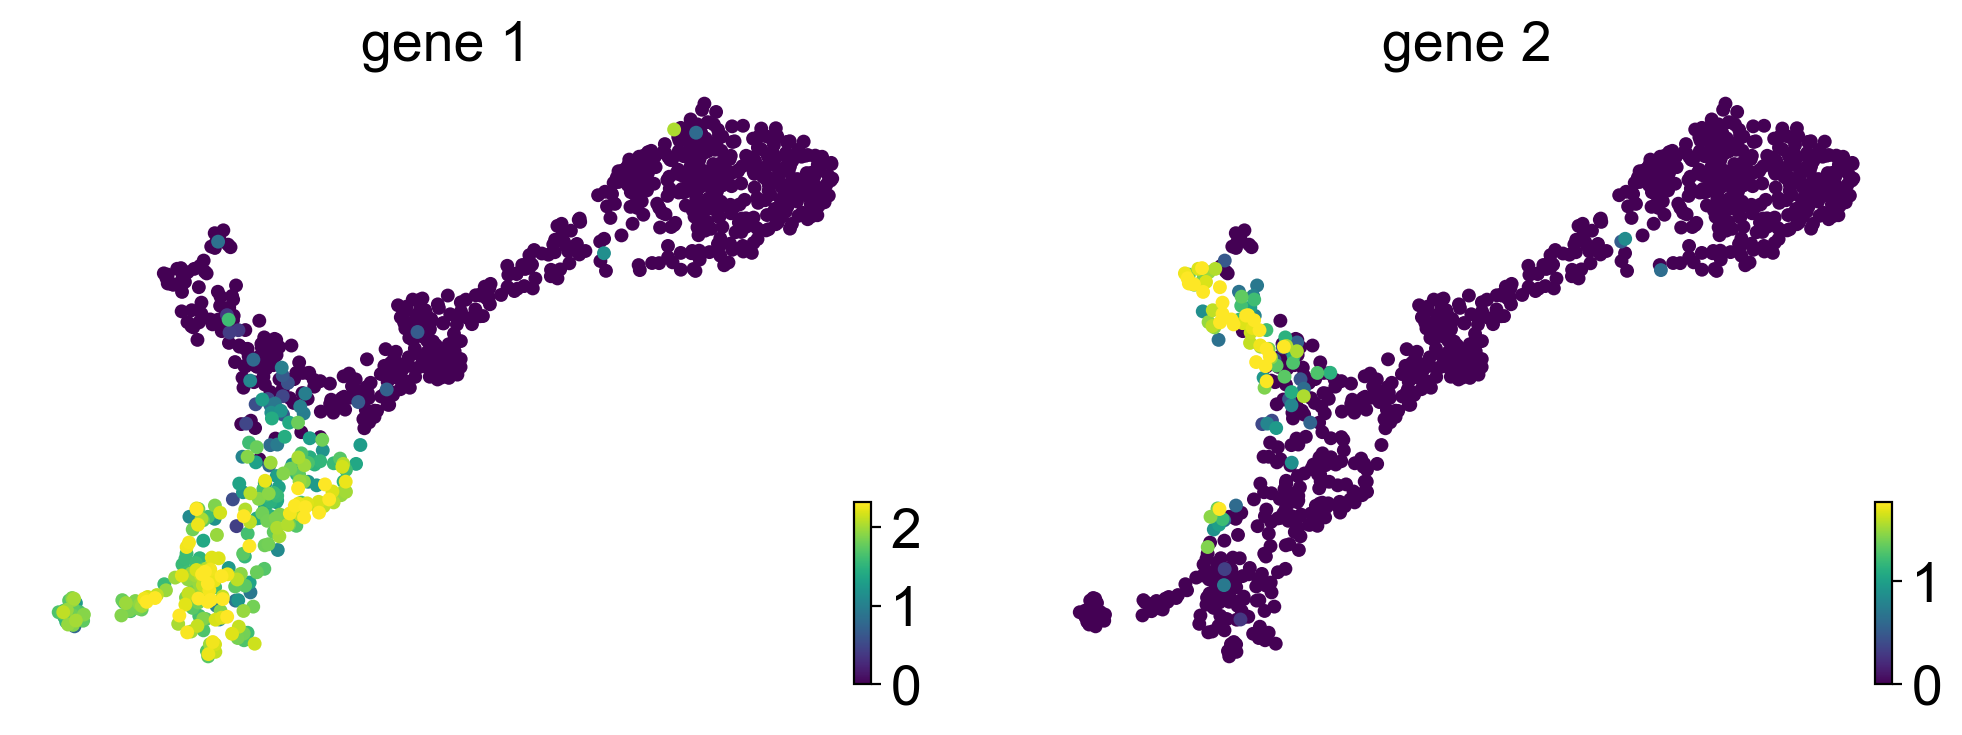

In [31]:
fig_kwargs = {'color': ['114','72'], 
              'perc': [0, 98], 
              'dpi': 100, 
              'title': ['gene 1', 'gene 2'], 
              'color_map': 'viridis', 
              'size': 100}
if save_figure: fig_kwargs['save'] = "gene_expression_embedding.pdf"
scv.pl.scatter(adata, **fig_kwargs)

Computing trends using `1` core(s)



    Finish (0:00:00)
Plotting trends


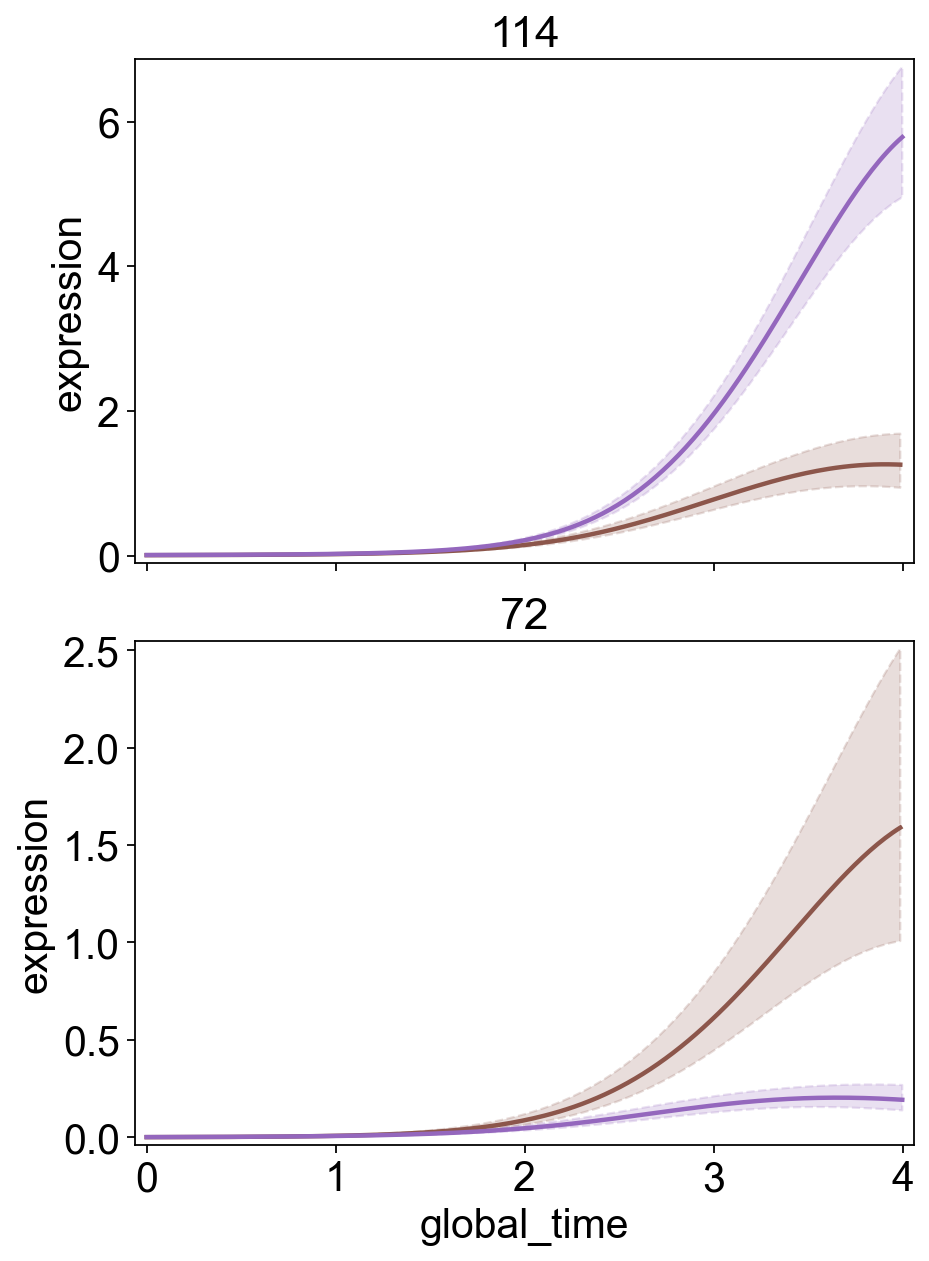

In [32]:
fig_kwargs = {'data_key': 'Ms', 
              'genes': ['114', '72'], 
              'ncols': 1, 
              'legend_loc': None, 
              'time_key': 'global_time', 
              'same_plot': True, 
              'hide_cells': True}
if save_figure: fig_kwargs['save'] = "gene_expression_time.pdf"

model = cr.ul.models.GAM(adata_raw, n_knots=6, spline_kwargs={'lam': 5})
cr.pl.gene_trends(adata_raw, model=model, **fig_kwargs)

## Show heatmap of potential lineage drivers

Find some genes which correlate well with fate probs

In [33]:
g_fwd.compute_lineage_drivers(use_raw=True)

Computing correlations for lineages `['sD -> sEndD' 'sC -> sEndC']` restricted to clusters `None` in layer `X` with `use_raw=True`
Adding `.lineage_drivers`
       `adata.raw.var['to sD -> sEndD']`
       `adata.raw.var['to sC -> sEndC']`
    Finish (0:00:00)


Select a lineage and compute the heatmap

In [34]:
lin = 'sD -> sEndD'
corr = adata.raw.var.sort_values(by=f"to {lin}", ascending=False)

corr = corr.head(50)
print(f"Selected {len(corr)} cells.")

Selected 50 cells.


Computing trends using `1` core(s)


did not converge

    Finish (0:00:04)


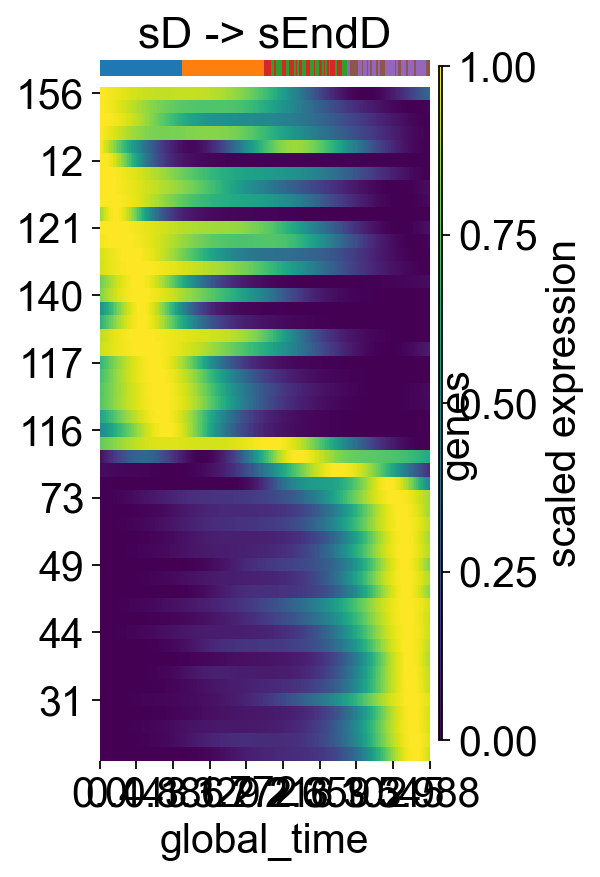

In [35]:
fig_kwargs = {'genes': corr.index, 
              'lineages':[lin], 
              'cluster_key': 'lineage', 
              'time_key': 'global_time', 
              'data_key': 'Ms', 
              'show_absorption_probabilities': False, 
              'figsize': (4, 6), 
              'show_all_genes': False, 
              'weight_threshold': (0.05, 0.05)}
if save_figure: fig_kwargs['save'] = 'heatmap.pdf'

model = cr.ul.models.GAM(adata_raw, n_knots=10)
cr.pl.heatmap(adata_raw, model, **fig_kwargs) 

Look at early, intermediate and late genes:

saving figure to file /Users/marius/Projects/cellrank_reproducibility/figures/fig_1_concept/early_late_genes.pdf


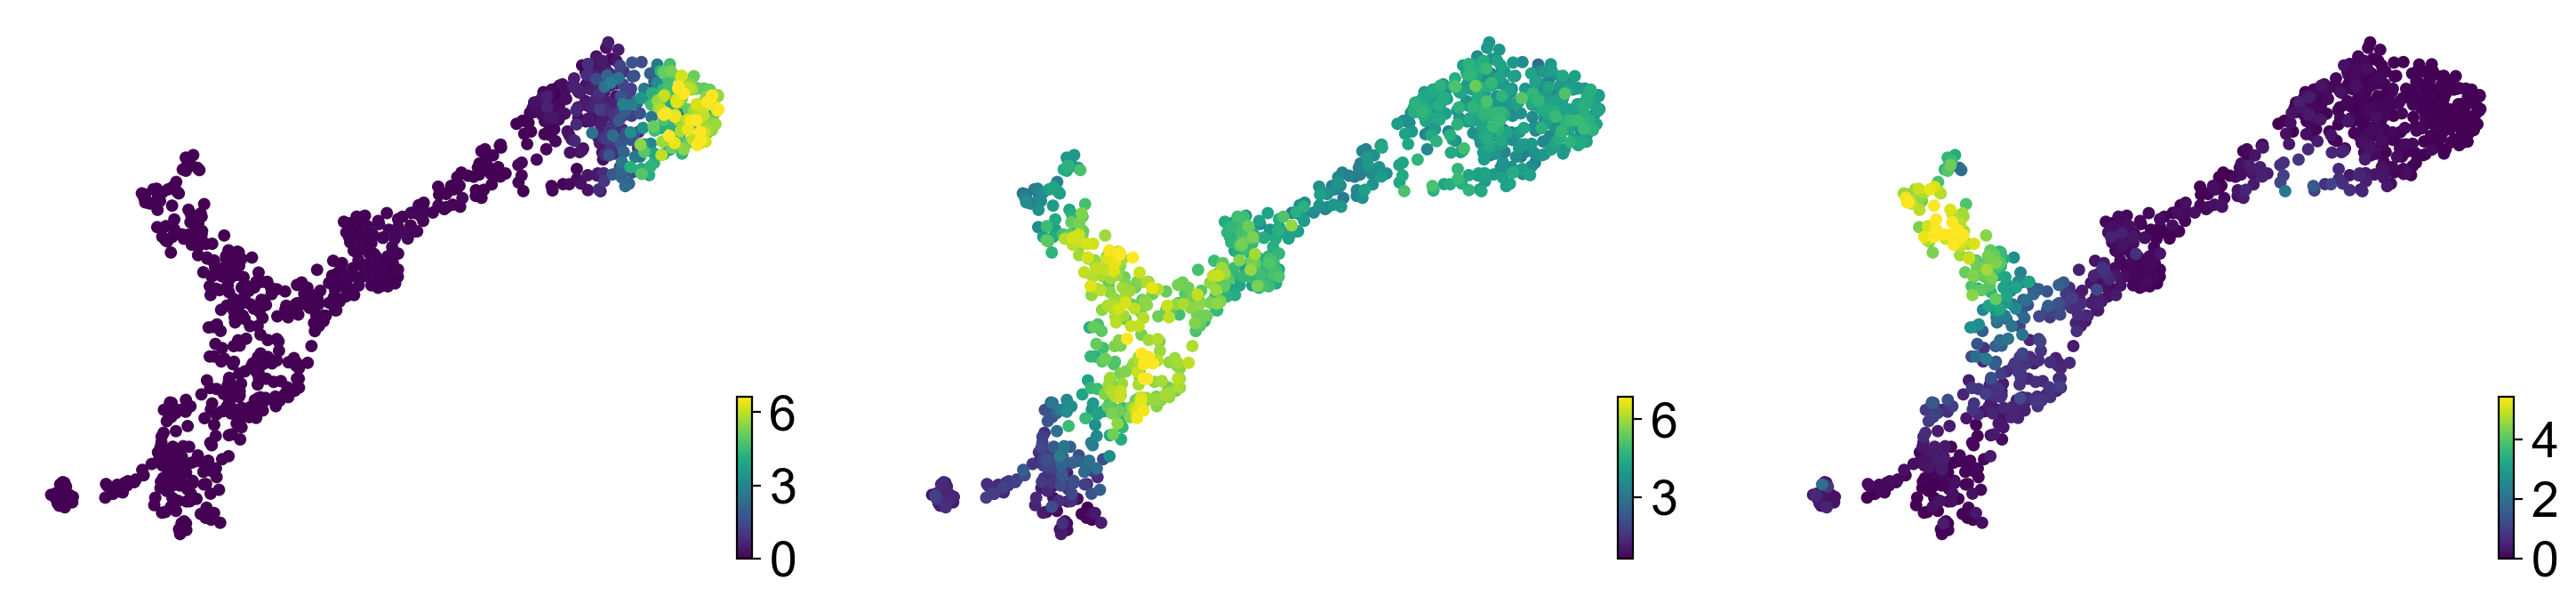

In [36]:
fig_kwargs = {'color': ['11', '54',  '43'], 
              'legend_loc': 'on data', 
              'layer': 'Ms', 
              'perc': [0, 99], 
              'color_map': 'viridis', 
              'title': '', 
              'dpi': 100, 
              'size': 100}
if save_figure: fig_kwargs['save'] = 'early_late_genes.pdf'

scv.pl.scatter(adata_raw, **fig_kwargs)